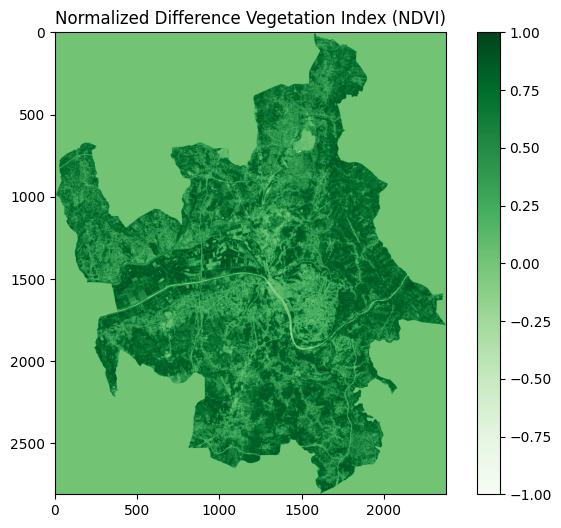

In [2]:
# exercise 1
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

red = 'Maps_and_GISWEB/fichaexercicios2/f2ex1/red_band.tif'
nir = 'Maps_and_GISWEB/fichaexercicios2/f2ex1/nir_band.tif'
out = 'Maps_and_GISWEB/fichaexercicios2/f2ex1/result.tif'

# Read the data from the input rasters
nir_ds = gdal.Open(nir, gdal.GA_ReadOnly)
red_ds = gdal.Open(red, gdal.GA_ReadOnly)

nir_band = nir_ds.GetRasterBand(1)
red_band = red_ds.GetRasterBand(1)

nir_data = nir_band.ReadAsArray().astype(np.float32)
red_data = red_band.ReadAsArray().astype(np.float32)

# Calculate the NDVI
ndvi_data = (nir_data - red_data) / (nir_data + red_data)

# Plot the NDVI image
plt.figure(figsize=(8, 6))
plt.imshow(ndvi_data, cmap='Greens', vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.title('Normalized Difference Vegetation Index (NDVI)')
plt.show()

nir_ds = None
red_ds = None


In [22]:
# exercise 2
from osgeo import gdal, ogr

contour_lines_ds = ogr.Open('Maps_and_GISWEB/fichaexercicios2/f2ex2/curvas_nivel.shp')
contour_layer = contour_lines_ds.GetLayer()

lmt_ds = ogr.Open('Maps_and_GISWEB/fichaexercicios2/f2ex2/lmt_1000m.shp')
lmt_layer = lmt_ds.GetLayer()

lmt_feature = lmt_layer.GetNextFeature()
lmt_geometry = lmt_feature.GetGeometryRef()
lmt_extent = lmt_geometry.GetEnvelope()

x_res = 10
y_res = 10

width = int((lmt_extent[1] - lmt_extent[0]) / x_res)
height = int((lmt_extent[3] - lmt_extent[2]) / y_res)

target_ds = gdal.GetDriverByName('GTiff').Create('DEM.tif', width, height, 1, gdal.GDT_Float32)

target_ds.SetGeoTransform((lmt_extent[0], x_res, 0, lmt_extent[3], 0, -y_res))

target_ds.SetProjection(contour_layer.GetSpatialRef().ExportToWkt())

gdal.RasterizeLayer(target_ds, [1], contour_layer, options=["ATTRIBUTE=ELEVATION"])

contour_lines_ds = None
lmt_ds = None
target_ds = None


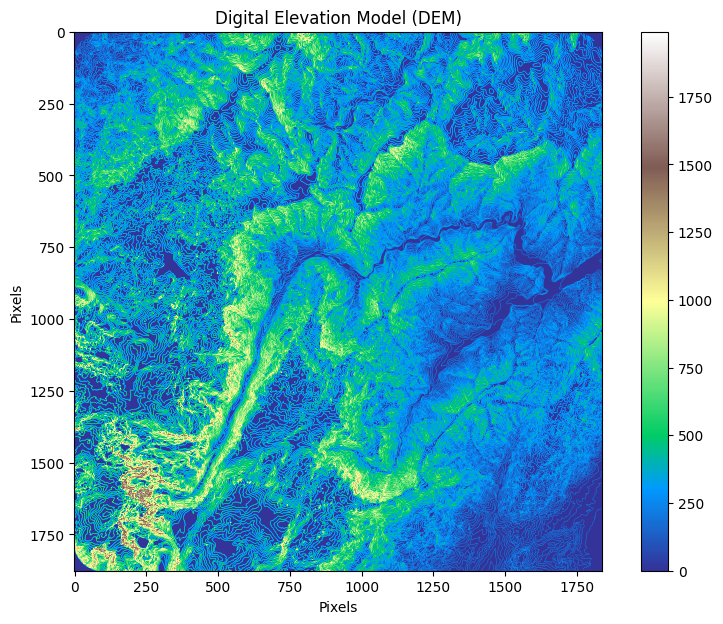

In [23]:
import matplotlib.pyplot as plt

dem_dataset = gdal.Open('DEM.tif')
dem_band = dem_dataset.GetRasterBand(1)

dem_data = dem_band.ReadAsArray()

plt.figure(figsize=(10, 7))
plt.imshow(dem_data, cmap='terrain')
plt.colorbar()
plt.title('Digital Elevation Model (DEM)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

dem_dataset = None


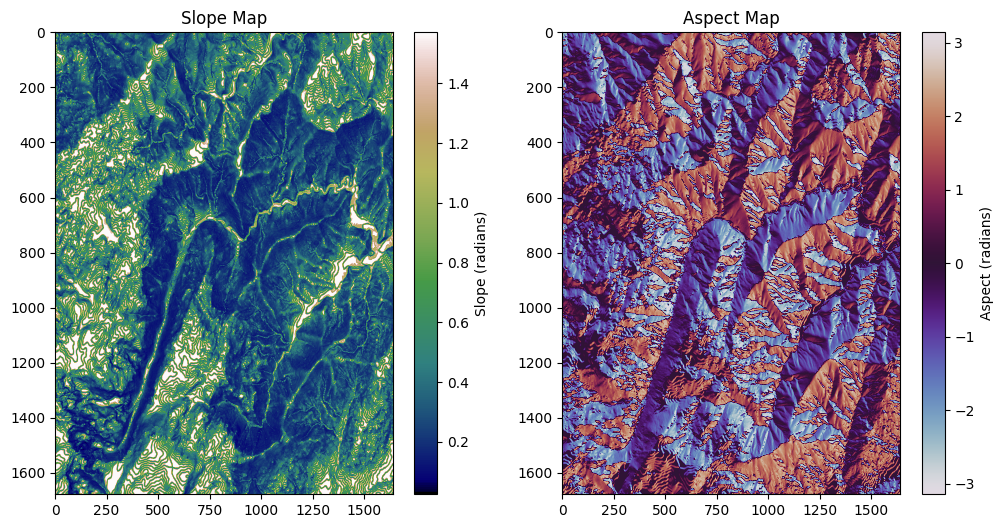

In [24]:
# exercise 3
from osgeo import gdal, gdalconst
import numpy as np
import matplotlib.pyplot as plt

dem_file_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex3/mdt.tif'

ds = gdal.Open(dem_file_path)

band = ds.GetRasterBand(1)
dem_data = band.ReadAsArray()

x, y = np.gradient(dem_data)
slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
aspect = np.arctan2(-x, y)

# Display the slope and aspect maps
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(slope, cmap='gist_earth', aspect='auto')
plt.title('Slope Map')
plt.colorbar(label='Slope (radians)')

plt.subplot(1, 2, 2)
plt.imshow(aspect, cmap='twilight', aspect='auto')
plt.title('Aspect Map')
plt.colorbar(label='Aspect (radians)')

plt.show()

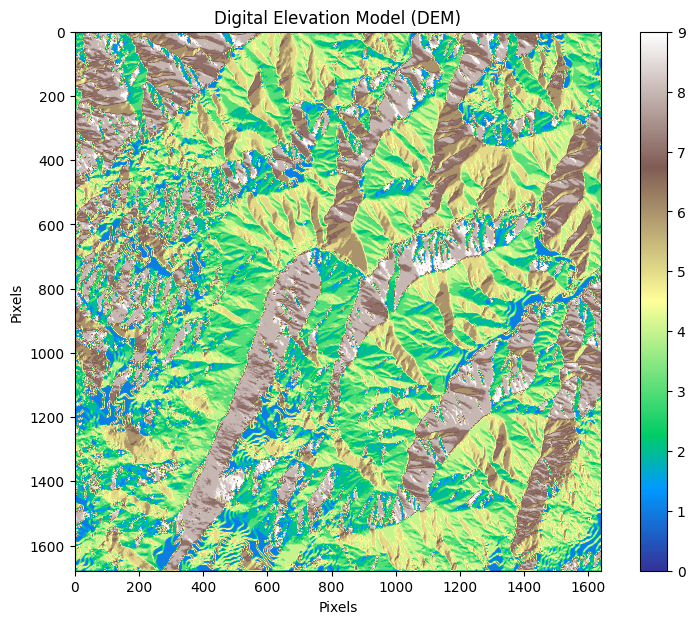

In [36]:
#exercise 4

from osgeo import gdal
import numpy as np

# Define the reclassification rules
rules = {
    1: [0],
    2: [45],
    3: [90],
    4: [135],
    5: [180],
    6: [225],
    7: [270],
    8: [315],
    9: [360]
}

# Function for reclassification
def reclassify(data, rules):
    result = np.zeros_like(data)
    for key, values in rules.items():
        for value in values:
            result[(data >= value - 22.5) & (data < value + 22.5)] = key
    return result

file_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex5/exposicao.tif'
ds = gdal.Open(file_path, gdal.GA_ReadOnly)

band = ds.GetRasterBand(1)
data = band.ReadAsArray().astype(np.float32)

reclassified_data = reclassify(data, rules)

plt.figure(figsize=(10, 7))
plt.imshow(reclassified_data, cmap='terrain')
plt.colorbar()
plt.title('Digital Elevation Model (DEM)')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

dem_dataset = None


In [31]:
# exercise 5
import rasterio
from rasterio.enums import Resampling
import numpy as np

with rasterio.open('Maps_and_GISWEB/fichaexercicios2/f2ex5/mdt.tif') as src_mdt, rasterio.open('Maps_and_GISWEB/fichaexercicios2/f2ex5/exposicao.tif') as src_exposicao:
    mdt = src_mdt.read(1)  # Read the first band
    exposicao = src_exposicao.read(1)

    # Apply conditions for altitude and southern exposure
    condition_altitude = mdt > 800
    condition_exposure = (exposicao > 202.5) & (exposicao < 247.5) 

    # Combine the conditions
    final_condition = np.logical_and(condition_altitude, condition_exposure)

    # # Create a new raster with the combined conditions
    profile = src_mdt.profile  # Use the profile from mdt as a template
    profile.update(count=1) 
    with rasterio.open('final_map.tif', 'w', **profile) as dst:
        dst.write(final_condition.astype(rasterio.uint8), 1)


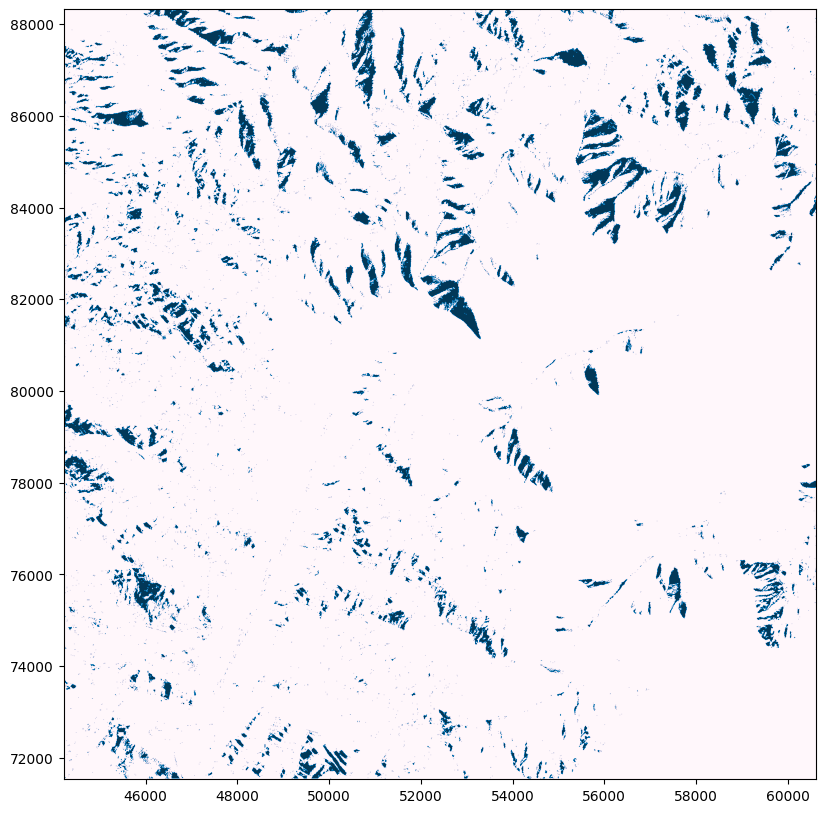

In [32]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

with rasterio.open('final_map.tif') as src:
    plt.figure(figsize=(10, 10))
    show(src, cmap='PuBu')
    plt.show()

In [21]:
# exercise 6
from osgeo import gdal, gdal_array
import numpy as np

zones_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex6/zones.tif'
slopes_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex6/declives.tif'
output_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex6/average_slope.tif'

ds_zones = gdal.Open(zones_path, gdal.GA_ReadOnly)
ds_slopes = gdal.Open(slopes_path, gdal.GA_ReadOnly)

zones_data = ds_zones.ReadAsArray()
slopes_data = ds_slopes.ReadAsArray()

# Calculate unique zone values
unique_zones = np.unique(zones_data)

# Initialize an empty array to store the average slopes
average_slope_data = np.zeros_like(zones_data, dtype=np.float32)

# Compute average slope for each zone
for zone in unique_zones:
    zone_indices = np.where(zones_data == zone)
    zone_slopes = slopes_data[zone_indices]
    average_slope = np.mean(zone_slopes)
    average_slope_data[zone_indices] = average_slope

driver = gdal.GetDriverByName('GTiff')
output_dataset = driver.Create(output_path, ds_zones.RasterXSize, ds_zones.RasterYSize, 1, gdal.GDT_Float32)

output_dataset.SetGeoTransform(ds_zones.GetGeoTransform())
output_dataset.SetProjection(ds_zones.GetProjection())

output_band = output_dataset.GetRasterBand(1)
output_band.WriteArray(average_slope_data)

# Compute statistics and set the NoData value
output_band.FlushCache()
output_band.SetNoDataValue(-9999)  # Set a suitable NoData value

# Compute statistics if needed
output_dataset.GetRasterBand(1).ComputeStatistics(False)

ds_zones = None
ds_slopes = None
output_dataset = None


/home/marta-ubuntu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


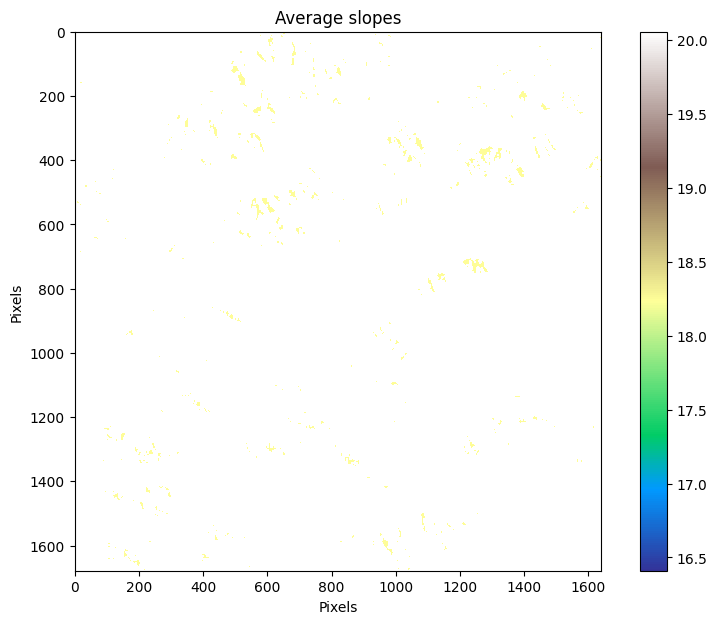

In [24]:
file_path = 'Maps_and_GISWEB/fichaexercicios2/f2ex6/average_slope.tif'
ds = gdal.Open(file_path, gdal.GA_ReadOnly)

band = ds.GetRasterBand(1)
data = band.ReadAsArray().astype(np.float32)

plt.figure(figsize=(10, 7))
plt.imshow(data, cmap='terrain')
plt.colorbar()
plt.title('Average slopes')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

dem_dataset = None

In [39]:
# exercise 7

In [12]:
# exercise 8

In [32]:
# exercise 9
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
from scipy.ndimage import distance_transform_edt
from pyproj import Transformer

hospitals_path = "Maps_and_GISWEB/fichaexercicios2/f2ex9/hospitais.shp"
hospitals = gpd.read_file(hospitals_path)

cost_surface_path = "Maps_and_GISWEB/fichaexercicios2/f2ex9/supcusto.tif"
cost_surface = rasterio.open(cost_surface_path)

cost_data = cost_surface.read(1)

# Calculate the distance transform
distance_transform = distance_transform_edt(cost_data)

# Generate a new raster to store the travel times
travel_time_raster = np.zeros_like(cost_data, dtype=np.float32)

# Iterate through each hospital
for idx, hospital in hospitals.iterrows():
    # Reproject the hospital point to the same CRS as the cost surface raster
    x, y = hospital.geometry.x, hospital.geometry.y
    transformer = Transformer.from_crs(hospitals.crs, cost_surface.crs, always_xy=True)
    x_cost, y_cost = transformer.transform(x, y)

    # Convert the hospital point to a pixel coordinate
    row, col = cost_surface.index(x_cost, y_cost)

    # Compute the Euclidean distance from the hospital
    distance_to_hospital = distance_transform + np.sqrt((row - x_cost)**2 + (col - y_cost)**2)

    # Update the travel time raster with the calculated distances
    travel_time_raster = np.where(travel_time_raster == 0, distance_to_hospital, np.minimum(travel_time_raster, distance_to_hospital))

# Write the travel time raster to a new file
with rasterio.open('travel_time_raster.tif', 'w', driver='GTiff', width=cost_surface.width, height=cost_surface.height, count=1, dtype=str(travel_time_raster.dtype), crs=cost_surface.crs, transform=cost_surface.transform) as dst:
    dst.write(travel_time_raster, 1)


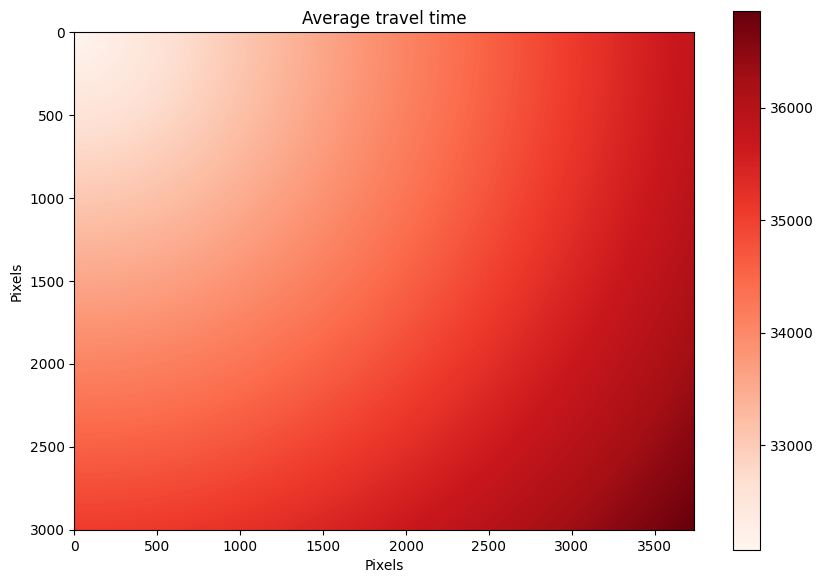

In [35]:
file_path = 'travel_time_raster.tif'
ds = gdal.Open(file_path, gdal.GA_ReadOnly)

band = ds.GetRasterBand(1)
data = band.ReadAsArray().astype(np.float32)

plt.figure(figsize=(10, 7))
plt.imshow(data, cmap='Reds')
plt.colorbar()
plt.title('Average travel time')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

dem_dataset = None